SelectMultiple(description='Combinations:', layout=Layout(height='350px', width='90%'), options=('Model: llama…

Button(description='Plot Cumulative Performance', style=ButtonStyle())

Button(description='Plot Mean Performance', style=ButtonStyle())

Output()

Button(description='Show Table', style=ButtonStyle())

Output()

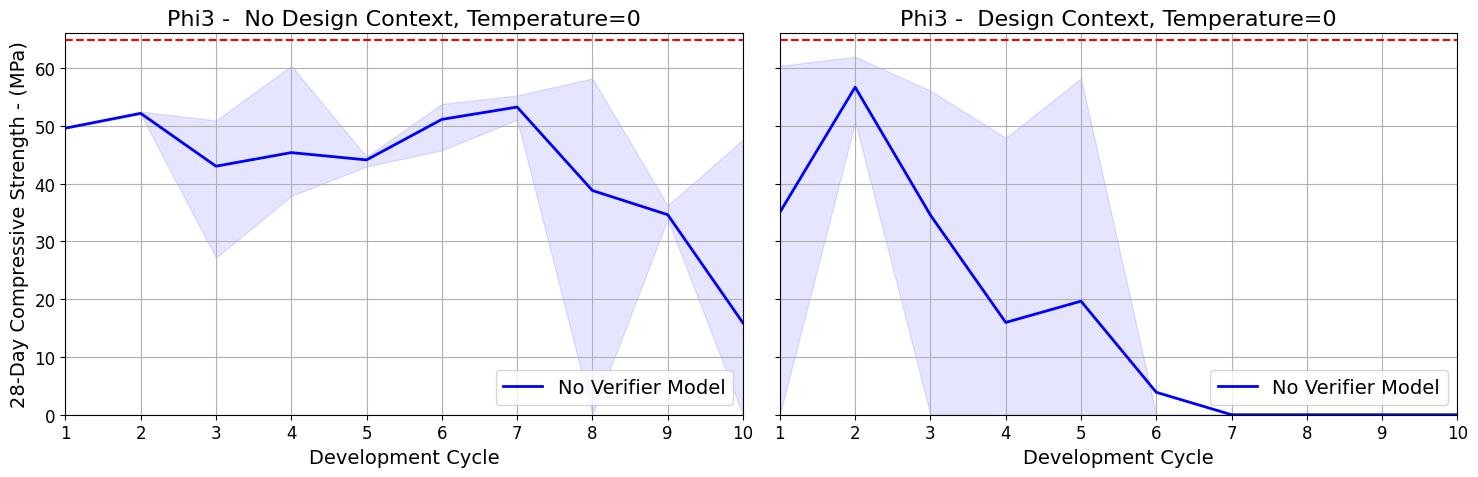

In [1]:
import pandas as pd
import numpy as np
import csv
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
from matplotlib import patches
from matplotlib.ticker import FuncFormatter
import math
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re
import os
import re
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Layout, Button
import collections
import re
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


def extract_info(filename):
    pattern = r"(?P<model>.*?)_(?P<prompt>Context|NoContext)_prompt_experiment_(?P<experiment>\d+)_temp_(?P<temp>[\d.]+)_target_(?P<target>Optimal|[\d.]+)_.*?_Dev_Budget_(?P<budget>\d+)_recursive_(?P<recursive>\d+)_.*?\.csv"
    match = re.match(pattern, filename)
    if match:
        # Return a tuple as explicitly stated
        return (match.group('model'), match.group('prompt'), match.group('temp'), match.group('target'), int(match.group('budget')), int(match.group('recursive')))
    return None


def unique_combinations(directory):
    unique_sets = set()
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            info = extract_info(filename)
            if info:
                unique_sets.add(info)  # This should work fine if info is a tuple

    # Convert the set to a list for sorting or further operations
    unique_list = list(unique_sets)
    unique_list.sort(key=lambda x: (x[2], x[0]))  # Example sorting logic

    return unique_list



def load_data(filename, budget):
    df = pd.read_csv(filename)
    strength = df['Compressive Strength'].values

    if len(strength) < budget:
        last_value = strength[-1] if len(strength) > 0 else 0
        strength = np.pad(strength, (0, budget - len(strength)), constant_values=last_value)
    return strength

def load_data_baseline(filename, budget):
    df = pd.read_csv(filename)
    strength = df['fc_28dGroundTruth'].values
    if len(strength) > 4:  # if more than initial samples, drop them
        strength = strength[4:]  # drop first 4 samples
    if len(strength) < budget:
        last_value = strength[-1] if len(strength) > 0 else 0
        strength = np.pad(strength, (0, budget - len(strength)), 'constant', constant_values=last_value)
    return strength


def load_selected_data(btn):
    data = collections.defaultdict(list)
    chain_reverse_mapping = {'Zero-Shot': '1', 'TT=3': '3' }  # Reverse mapping textual representations to numeric strings

    for selected in combo_widget.value:
        split_selected = selected.split(", ")

        # For regular models
        if len(split_selected) == 5 and "Prompt" in selected:  # Make sure there are 5 elements
            selected_model = split_selected[0].split(": ")[1]
            selected_prompt = split_selected[1].split(": ")[1]
            selected_temp = split_selected[2].split(": ")[1]
            selected_target = split_selected[3].split(": ")[1]
            selected_chain_text = re.split(r":\s*", split_selected[4].strip())[1]
            selected_chain_numeric = chain_reverse_mapping.get(selected_chain_text, selected_chain_text)  # Map the text to its numeric representation
            
            
            for filename in os.listdir('../results/LLM'):
                info = extract_info(filename)
                
                if info and info[:-2] == (selected_model, selected_prompt, selected_temp, selected_target) and str(info[-1]) == selected_chain_numeric:
                    strength = load_data(os.path.join('../results/LLM', filename), info[-2])  # Use the budget
                    data[(selected_model, selected_prompt, selected_temp, selected_target, selected_chain_text)].append(strength)
                    # If the condition for TT=3 or TT=5 is met, adjust the strength data
                    if selected_chain_text in ['TT=3', 'TT=5']:
                        # Ensure the length is at least 14 to safely drop first 4 samples
                        if len(strength) >= 14:
                            strength = strength[4:14]  # Adjust to keep the 10 relevant samples

        # For baseline models
        elif len(split_selected) == 4 and "Initial Samples" in selected:
            selected_model, selected_init_samples, selected_target, selected_budget = split_selected
            selected_model = selected_model.split(": ")[1]
            selected_init_samples = selected_init_samples.split(": ")[1]
            selected_target = selected_target.split(": ")[1]
            selected_budget = selected_budget.split(": ")[1]
            if selected_model == 'BO':
                for directory in ['../results/BO']:
                    for filename in os.listdir(directory):
                        try:
                            info = extract_info_baseline(filename)
                            strength = load_data_baseline(os.path.join(directory, filename), info[-1])
                            data[info[:-1]].append(strength)
                        except:
                            pass
            elif selected_model =='RF':
                for directory in ['../results/RF']:
                    for filename in os.listdir(directory):
                        try:
                            info = extract_info_baseline(filename)
                            strength = load_data_baseline(os.path.join(directory, filename), info[-1])
                            data[info[:-1]].append(strength)
                        except:
                            pass
            elif selected_model =='RP':
                for directory in ['../results/RP']:
                    for filename in os.listdir(directory):
                        try:
                            info = extract_info_baseline(filename)
                            strength = load_data_baseline(os.path.join(directory, filename), info[-1])
                            data[info[:-1]].append(strength)
                        except:
                            pass


    return data

    print("Data Loaded Successfully!")
    
    return data
def extract_info_baseline(filename):
    pattern = r"experiment_(?P<experiment>\d+)_(?P<model>.*?)_(initialsample_(?P<initialsample>\d+)?_)?target_(?P<target>.*?)_%_Dev_Budget_(?P<budget>\d+)_.*"
    match = re.match(pattern, filename)
    if match:
        model = match.group('model')
        experiment = int(match.group('experiment'))
        initial_sample_size = int(match.group('initialsample')) if match.group('initialsample') else 0
        target = match.group('target')
        budget = int(match.group('budget'))
        return model, initial_sample_size, target, budget

def unique_combinations_baseline(directory):
    unique_lists = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            info = extract_info_baseline(filename)
            if info:
                unique_lists.append(info)
    
    # Sort list based on initial_sample_size (int) first, Model (str) second
    unique_lists = list(set(unique_lists)) # Remove duplicates
    unique_lists.sort(key=lambda x: (x[2], x[0])) # Sort
    
    return unique_lists

directories = ['../results/hackathon_results','../results/BO', '../results/RF', '../results/RP']

# Get the unique combinations for each type of model
unique_sets = []
for directory in directories:
    if directory == '../results/hackathon_results':
        unique_sets += unique_combinations(directory)
    else:
        unique_sets += unique_combinations_baseline(directory)
# Generate the unique list
unique_list = []
for unique_set in unique_sets:
    if 'mixtral-instruct-awq' in unique_set[0] or 'gpt-3.5-turbo' in unique_set[0] or 'gpt-4-1106-preview' in unique_set[0] or 'phi3' in unique_set[0]  or 'llama3' in unique_set[0]:  # For regular models
        model, prompt, temp, target, _, prompt_chain = unique_set
        chain_desc = "Zero-Shot" if prompt_chain == 1 else "TT=3"
        unique_list.append(f"Model: {model}, Prompt: {prompt}, Temp: {temp}, Target: {target}, Prompt chain: {chain_desc}")
    else:  # For baseline models
        model, init_samples, target, budget = unique_set
        unique_list.append(f"Model: {model}, Initial Samples: {init_samples}, Target: {target}, Budget: {budget}")

combo_widget = widgets.SelectMultiple(
    options=unique_list,
    description='Combinations:',
    layout=Layout(width='90%', height='350px')
)


def plot_results(data, desired_target):
    
    with plot_output:
        # Set global font sizes
        plt.rcParams.update({'font.size': 14})  # Adjust as needed
        plt.rcParams.update({'axes.titlesize': 16})  # Title font size
        plt.rcParams.update({'axes.labelsize': 14})  # Axis label font size
        plt.rcParams.update({'xtick.labelsize': 12})  # X tick label size
        plt.rcParams.update({'ytick.labelsize': 12})  # Y tick label size
        plt.rcParams.update({'legend.fontsize': 14})  # Legend font size
        
        # Define the sorting key function
        def sorting_key(config):
            # Custom order for 'Information Quality'
            info_quality_order = {'NoContext': 0, 'Context': 1}
            if len(config) == 5:  # For chat models with full configuration
                info_quality = config[1]
                return (0, info_quality_order.get(info_quality, -1)) + config  # 0 to prioritize chat models
            else:  # For baseline methods, give a higher initial sort value
                return (1, ) + config  # 1 to ensure baseline methods come after chat models

        # Sort the data items
        sorted_data = sorted(data.items(), key=lambda item: sorting_key(item[0]))
        
        # Group data by model, strategy, and temperature, handling different config lengths
        grouped_data = {}
        for config, strengths in sorted_data:
            if len(config) == 5:  # Configs with TT
                group_key = tuple(config[:-1])  # Exclude the TT parameter
                # Assign a string based on the value of config[-1]
                tt_index = "Zero-Shot" if config[-1] == "1" else "TT=3" if config[-1] == "3" else "TT=5" if config[-1] == "2" else "No Feedback" if config[-1] == "3" else config[-1]
            else:  # Baseline methods
                group_key = config
                tt_index = "Zero-Shot"  # Assuming baseline is equivalent to Zero-Shot

            if group_key not in grouped_data:
                grouped_data[group_key] = {"Zero-Shot": None, "TT=3": None, "TT=5": None,"No Feedback": None}  # Using strings as keys
            grouped_data[group_key][tt_index] = strengths

        num_configs = len(grouped_data.keys())
        ncols = 2

        nrows = int(math.ceil(num_configs / ncols))
        fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=True, sharey=True)
        
        # Ensure axs is always a 2D array
        if nrows == 1 or ncols == 1:
            axs = axs.reshape(nrows, ncols)

        tt_colors = ['blue', 'green', 'pink','cyan']  # Blue for Baseline (TT=0), Orange for Increased TT (TT=1)

        y_min = np.inf
        y_max = -np.inf

        for idx, (config, strengths_pair) in enumerate(grouped_data.items()):
            row = idx // ncols
            col = idx % ncols

            for tt, all_strengths in enumerate(strengths_pair.values()):  # Use .values()
                if all_strengths is None:
                    continue  # Skip if no data for this TT value

                # Calculate cumulative max for each experiment
                cumulative_strengths = [np.maximum.accumulate(strength) for strength in all_strengths]
                #cumulative_strengths=all_strengths
                # Calculate the mean and the 10th and 90th percentiles
                mean_strengths = np.mean(cumulative_strengths, axis=0)
                lower_bound = np.percentile(cumulative_strengths, 10, axis=0)
                upper_bound = np.percentile(cumulative_strengths, 90, axis=0)

                iterations = list(range(1, len(mean_strengths) + 1))

                # Plotting
                label = 'TT=5' if tt == 2 else'Verifier Model' if tt == 1 else "No Feedback" if tt == 3 else 'No Verifier Model'  
                axs[row, col].plot(iterations, mean_strengths, color=tt_colors[tt], label=label, linewidth=2)
                axs[row, col].fill_between(iterations, lower_bound, upper_bound, alpha=0.1, color=tt_colors[tt])

                # Update global y-axis limits
                y_min = min(y_min, lower_bound.min())
                y_max = max(y_max, upper_bound.max())

            # Add labels, title, and legend for each subplot
            axs[row, col].set_xlabel('Development Cycle')
            axs[row, 0].set_ylabel('28-Day Compressive Strength - (MPa)')
            # Set title based on the length of config
            if len(config) == 4:  # For chat models with full configuration
                title = ''
                if config[0] == 'mixtral-instruct-awq': 
                    title = 'Mixtral-8x7b - ' 
                if config[0] == 'gpt-3.5-turbo':
                    title = "GPT-3.5 - "
                if config[0] == 'gpt-4-1106-preview':
                    title = "GPT-4 - "  
                if config[0] == 'phi3':
                    title = "Phi3 - "
                if config[0] == 'llama3':
                    title = "Llama3 - "
                title += f" {'No Design Context' if {config[1]} == {'NoContext'} else 'Design Context'}"
                title += f", Temperature={config[2]}"
                
                axs[row, col].legend(loc='lower right')
            else:  # For baseline methods
                
                if {config[0]} == {'BO'}:
                    title = f"Gaussian Process Regression"
                elif {config[0]} == {'RF'}:
                    title = f"Random Forest"
                elif {config[0]} == {'RP'}:
                    title = f"Random Draw"
                else:
                    title = f"Baseline Method: {config[0]}"
            
                    
            axs[row, col].set_title(title)
            axs[row, col].grid(True)
            
            # Add horizontal line for the desired target strength
            axs[row, col].axhline(y=desired_target, color='r', linestyle='--')
            axs[row, col].set_xlim(1, 10)

        # Normalize y-axis for all subplots
        for ax in axs.flat:
            ax.set_ylim([0, 66])

        plt.tight_layout()
        plt.savefig(f"../results/plots/cumulative/cumulative {title} {label}.png")
        plt.show()

        
def plot_mean_results(data, desired_target):
    
    with plot_output:
        # Set global font sizes
        plt.rcParams.update({'font.size': 14})  # Adjust as needed
        plt.rcParams.update({'axes.titlesize': 16})  # Title font size
        plt.rcParams.update({'axes.labelsize': 14})  # Axis label font size
        plt.rcParams.update({'xtick.labelsize': 12})  # X tick label size
        plt.rcParams.update({'ytick.labelsize': 12})  # Y tick label size
        plt.rcParams.update({'legend.fontsize': 14})  # Legend font size

        # Define the sorting key function
        def sorting_key(config):
            # Custom order for 'Information Quality'
            info_quality_order = {'NoContext': 0, 'Context': 1}
            if len(config) == 5:  # For chat models with full configuration
                info_quality = config[1]
                return (0, info_quality_order.get(info_quality, -1)) + config  # 0 to prioritize chat models
            else:  # For baseline methods, give a higher initial sort value
                return (1, ) + config  # 1 to ensure baseline methods come after chat models

        # Sort the data items
        sorted_data = sorted(data.items(), key=lambda item: sorting_key(item[0]))

        # Group data by model, strategy, and temperature, handling different config lengths
        grouped_data = {}
        for config, strengths in sorted_data:
            if len(config) == 5:  # Configs with TT
                group_key = tuple(config[:-1])  # Exclude the TT parameter
                # Assign a string based on the value of config[-1]
                tt_index = "Zero-Shot" if config[-1] == "0" else "TT=3" if config[-1] == "1" else "TT=5" if config[-1] == "2" else "No Feedback" if config[-1] == "3"  else config[-1]
            else:  # Baseline methods
                group_key = config
                tt_index = "Zero-Shot"  # Assuming baseline is equivalent to Zero-Shot

            if group_key not in grouped_data:
                grouped_data[group_key] = {"Zero-Shot": None, "TT=3": None, "TT=5": None, "No Feedback": None}  # Using strings as keys
            grouped_data[group_key][tt_index] = strengths

        num_configs = len(grouped_data.keys())
        ncols = 2
        nrows = int(math.ceil(num_configs / ncols))
        fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=True, sharey=True)
        
        # Ensure axs is always a 2D array
        if nrows == 1 or ncols == 1:
            axs = axs.reshape(nrows, ncols)

        tt_colors = ['blue', 'green', 'pink','cyan']  # Blue for Baseline (TT=0), Orange for Increased TT (TT=1)

        y_min = np.inf
        y_max = -np.inf

        for idx, (config, strengths_pair) in enumerate(grouped_data.items()):
            row = idx // ncols
            col = idx % ncols

            for tt, all_strengths in enumerate(strengths_pair.values()):  # Use .values()
                if all_strengths is None:
                    continue  # Skip if no data for this TT value

                # Calculate cumulative max for each experiment
                
        
                # Calculate the mean and the 10th and 90th percentiles
                mean_strengths = np.mean(all_strengths, axis=0)
                lower_bound = np.percentile(all_strengths,10, axis=0)
                upper_bound = np.percentile(all_strengths, 90, axis=0)

                iterations = list(range(1, len(mean_strengths) + 1))

                # Plotting
                label = 'TT=5' if tt == 2 else'Verifier Model' if tt == 1 else "No Feedback" if tt == 3 else 'No Verifier Model'  
                axs[row, col].plot(iterations, mean_strengths, color=tt_colors[tt], label=label, linewidth=2)
                axs[row, col].fill_between(iterations, lower_bound, upper_bound, alpha=0.1, color=tt_colors[tt])

                # Update global y-axis limits
                y_min = min(y_min, lower_bound.min())
                y_max = max(y_max, upper_bound.max())

            # Add labels, title, and legend for each subplot
            axs[row, col].set_xlabel('Development Cycle')
            axs[row, 0].set_ylabel('28-Day Compressive Strength - (MPa)')
            # Set title based on the length of config
            if len(config) == 4:  # For chat models with full configuration
                title = ''
                if config[0] == 'mixtral-instruct-awq': 
                    title = 'Mixtral-8x-7b - '
                if config[0].strip() == 'gpt-3.5-turbo':
                    title = "GPT-3.5 - "
                if config[0] == 'gpt-4-1106-preview':
                    title = "GPT-4 - "  
                if config[0] == 'phi3':
                    title = "Phi3 - "
                if config[0] == 'llama3':
                    title = "Llama3 - "
                title += f" {'No Design Context' if {config[1]} == {'NoContext'} else 'Design Context'}"
                title += f", Temperature={config[2]}"
            
                axs[row, col].legend(loc='lower right')
            else:  # For baseline methods
                
                if {config[0]} == {'BO'}:
                    title = f"Gaussian Process Regression"
                elif {config[0]} == {'RF'}:
                    title = f"Random Forest"
                elif {config[0]} == {'RP'}:
                    title = f"Random Draw"
                else:
                    title = f"Baseline Method: {config[0]}"
            
                    
            axs[row, col].set_title(title)
            axs[row, col].grid(True)
            
            # Add horizontal line for the desired target strength
            axs[row, col].axhline(y=desired_target, color='r', linestyle='--')
            axs[row, col].set_xlim(1, 10)

        # Normalize y-axis for all subplots
        for ax in axs.flat:
            ax.set_ylim([0, 66])

        plt.tight_layout()
        plt.savefig(f"../results/plots/mean/mean {title} {label}.png")
        plt.show();       
        
# Example usage
# plot_results(data, desired_target)

        
import threading
plot_output = widgets.Output()

# Create a lock
lock = threading.Lock()

def on_load_and_plot(btn):
    # Acquire the lock
    if not lock.acquire(blocking=False):
        print('Another session is running, please wait...')
        return

    # Clear previous plots from the Output widget
    plot_output.clear_output(wait=True)

    data = load_selected_data(btn)  # store the returned data in a variable

    # Draw the new plot inside the Output widget
    with plot_output:
        plot_results(data, desired_target= 64.86370000000001)

    # Release the lock
    lock.release();
    
def on_load_and_plot_mean(btn):
    # Acquire the lock
    if not lock.acquire(blocking=False):
        print('Another session is running, please wait...')
        return

    # Clear previous plots from the Output widget
    plot_output.clear_output(wait=True)

    data = load_selected_data(btn);  # store the returned data in a variable

    # Draw the new plot inside the Output widget
    with plot_output:
        plot_mean_results(data, desired_target= 64.86370000000001);

    # Release the lock
    lock.release()    
# Define the button here
load_button = widgets.Button(description='Plot Cumulative Performance')
load_button.on_click(on_load_and_plot)

load_mean_button = widgets.Button(description='Plot Mean Performance')
load_mean_button.on_click(on_load_and_plot_mean)
#display(combo_widget, load_button, plot_output)

##########################
# Add Table below:


from IPython.display import display

def show_table(data):
    # print(data)
    def sorting_key(config):
        info_quality_order = {'NoContext': 0, 'Context': 1}
        if len(config) == 5:  # For chat models with full configuration
            return (0, info_quality_order.get(config[1], -1)) + config
        else:  # For baseline methods
            return (1, ) + config

    def format_config_label(config):
        if len(config) == 5:  # For chat models
            verifier_config = ''
            if config[4] == 'Zero-Shot':
                verifier_config = 'No Verifier Model'
            else:
                verifier_config = 'Verifier Model'
            return f"{config[0]}, {config[1]}, {verifier_config}"
        else:  # For baseline methods
            return f"Baseline Method: {config[0]}"

    def highlight_max(s):
        is_max = s == s.max()
        return ['font-weight: bold' if v else '' for v in is_max]

    def highlight_second(s):
        ordered = s.sort_values(ascending=False)
        if len(ordered) > 1:
            is_second = s == ordered.iloc[1]
        else:
            is_second = [False] * len(s)
        return ['text-decoration: underline' if v else '' for v in is_second]

    def highlight_third(s):
        ordered = s.sort_values(ascending=False)
        if len(ordered) > 2:
            is_third = s == ordered.iloc[2]
        else:
            is_third = [False] * len(s)
        return ['font-style: italic' if v else '' for v in is_third]

    sorted_data = sorted(data.items(), key=lambda item: sorting_key(item[0]))
    mean_dict = {'1st': [],'2nd': [],'3rd': [],'4th': [], '5th': [],'6th': [],'7th': [],'8th': [],'9th': [], '10th': [], 'Variance': [], 'Mean' : []}
    lower_bound_dict =  {'1st': [],'2nd': [],'3rd': [],'4th': [], '5th': [],'6th': [],'7th': [],'8th': [],'9th': [], '10th': [],'Variance': []}
    configs = []
    threshold = 64.86370000000001

    for config, all_strengths in sorted_data:
        label = format_config_label(config)
        
        configs.append(label)
        cum_strengths = [np.maximum.accumulate(strength) for strength in all_strengths]
        #all_strengths = all_strengths
        mean_strengths = np.mean(all_strengths, axis=0)
        lower_bound = np.percentile(cum_strengths, 10, axis=0)
        indices = [0,1,2,3,4,5,6,7,8,9]
        sum_all_strengths = sum(sum(all_strengths))
        all_strength_one_list = [x for xs in all_strengths for x in xs ]
        avg_strength = sum_all_strengths / len(all_strength_one_list)

        for i, idx in enumerate(indices):
            mean_value = mean_strengths[idx] if idx < len(mean_strengths) else np.nan
            lower_bound_value = lower_bound[idx] if idx < len(lower_bound) else np.nan
            mean_dict[list(mean_dict.keys())[i]].append(mean_value)
            lower_bound_dict[list(lower_bound_dict.keys())[i]].append(lower_bound_value)
        
        # mean_bias = np.mean(np.mean(all_strengths, axis=0))
        # mean_lower_bound_bias = np.mean(np.percentile(all_strengths, 10, axis=0))
        # mean_dict[list(mean_dict.keys())[10]].append(mean_bias)
        # lower_bound_dict[list(lower_bound_dict.keys())[10]].append(mean_lower_bound_bias)
        
        mean_variance = np.std(np.mean(all_strengths, axis=0))
        mean_lower_bound_variance = np.std(np.percentile(all_strengths, 10, axis=0))
        mean_dict[list(mean_dict.keys())[10]].append(mean_variance)
        mean_dict[list(mean_dict.keys())[11]].append(avg_strength)
        lower_bound_dict[list(lower_bound_dict.keys())[10]].append(mean_lower_bound_variance)

    df_mean = pd.DataFrame(mean_dict, index=configs).applymap(lambda x: round(x, 2))
    df_lower_bound = pd.DataFrame(lower_bound_dict, index=configs).applymap(lambda x: round(x, 2))

    print("Mean values:")
    display(df_mean.style.format("{:.1f}").apply(highlight_max).apply(highlight_second).apply(highlight_third))
    print("Lower bound values:")
    display(df_lower_bound.style.format("{:.1f}").apply(highlight_max).apply(highlight_second).apply(highlight_third))
 
    df_mean.to_csv(os.path.join('../results/', 'mean_values.csv'), sep=';', decimal=',', index=True)
    df_lower_bound.to_csv(os.path.join('../results/', 'lower_bound_values.csv'), sep=';', decimal=',', index=True)

# Create a button for showing the table
show_button = widgets.Button(description='Show Table')

def load_selected_data(btn):
    
    data = collections.defaultdict(list)
    chain_reverse_mapping = {'Zero-Shot': '1', 'TT=3': '3','TT=5': '4','No Feedback': '5' }  # Reverse mapping textual representations to numeric strings

    for selected in combo_widget.value:
        split_selected = selected.split(", ")

        # For regular models
        if len(split_selected) == 5 and "Prompt" in selected:  # Make sure there are 5 elements
            selected_model = split_selected[0].split(": ")[1]
            selected_prompt = split_selected[1].split(": ")[1]
            selected_temp = split_selected[2].split(": ")[1]
            selected_target = split_selected[3].split(": ")[1]
            selected_chain_text = re.split(r":\s*", split_selected[4].strip())[1]
            selected_chain_numeric = chain_reverse_mapping.get(selected_chain_text, selected_chain_text)  # Map the text to its numeric representation
            
            
            for filename in os.listdir('../results/hackathon_results'):
                info = extract_info(filename)
                if info and info[:-2] == (selected_model, selected_prompt, selected_temp, selected_target) and str(info[-1]) == selected_chain_numeric:
                    strength = load_data(os.path.join('../results/hackathon_results', filename), info[-2])  # Use the budget
                    data[(selected_model, selected_prompt, selected_temp, selected_target, selected_chain_text)].append(strength)
                    # If the condition for TT=3 or TT=5 is met, adjust the strength data
                    if selected_chain_text in ['TT=3', 'TT=5']:
                        # Ensure the length is at least 14 to safely drop first 4 samples
                        if len(strength) >= 14:
                            strength = strength[4:14]  # Adjust to keep the 10 relevant samples

        # For baseline models
        elif len(split_selected) == 4 and "Initial Samples" in selected:
            selected_model, selected_init_samples, selected_target, selected_budget = split_selected
            selected_model = selected_model.split(": ")[1]
            selected_init_samples = selected_init_samples.split(": ")[1]
            selected_target = selected_target.split(": ")[1]
            selected_budget = selected_budget.split(": ")[1]
            if selected_model == 'BO':
                for directory in ['../results/BO']:
                    for filename in os.listdir(directory):
                        try:
                            info = extract_info_baseline(filename)
                            strength = load_data_baseline(os.path.join(directory, filename), info[-1])
                            data[info[:-1]].append(strength)
                        except:
                            pass
            elif selected_model =='RF':
                for directory in ['../results/RF']:
                    for filename in os.listdir(directory):
                        try:
                            info = extract_info_baseline(filename)
                            strength = load_data_baseline(os.path.join(directory, filename), info[-1])
                            data[info[:-1]].append(strength)
                        except:
                            pass
            elif selected_model =='RP':
                for directory in ['../results/RP']:
                    for filename in os.listdir(directory):
                        try:
                            info = extract_info_baseline(filename)
                            strength = load_data_baseline(os.path.join(directory, filename), info[-1])
                            data[info[:-1]].append(strength)
                        except:
                            pass


    return data
def on_show_table(btn):
    # Acquire the lock
    if not lock.acquire(blocking=False):
        print('Another session is running, please wait...')
        return

    # Clear previous tables from the Output widget
    table_output.clear_output(wait=True)
    
    data = load_selected_data(btn)  # we assume that this function loads the selected data

    # Draw the new table inside the Output widget
    with table_output:
        # data = load_selected_data(btn)
        # print(data)
        show_table(data)

    # # Release the lock
    lock.release()

show_button.on_click(on_show_table)

table_output = widgets.Output()

display(combo_widget, load_button,load_mean_button, plot_output, show_button, table_output);
